In [1]:
using Statistics
using Plots
using BenchmarkTools
using Profile
using FFTW
using Statistics
using Optim
using Images, FileIO, ImageIO
using Printf
using Revise
using Profile
using LinearAlgebra
using Random
using Distributions
using FITSIO
using SparseArrays

In [2]:
push!(LOAD_PATH, pwd()*"/../../../main")
using DHC_2DUtils
push!(LOAD_PATH, pwd()*"/../../")
using Deriv_Utils_New
using Data_Utils
using Visualization
using ReconFuncs

### Why don't reg im S based images work better?

In [3]:
##Why Don't Reg plots move away?? 
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/1000_fullcov_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["s_targ_mean"], gttarget["dict"]["s_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_init = DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_recon = DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask]
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True0.2792624951944618
3830.952426245689
Init269.1009695044303
0.0
Recon117.71091621771856
47.246177184049394


The true image actually has a worse loss than BOTH the reconstructed image and the initial image, simply because lambda is too high to even let the init get to the true image.
**NEED TO CHANGE THE LOSS FUNCTION OR AT LEAST LAMBDA FOR THE REG CASE** <br/>
For the regular case with no log coeffs, you can't use the expected chisquare value for l1true. It should instead be 1 since that distribution peaked near 1.

In [4]:
experiment = load("../../StandardizedExp/Nx64/Data_1000.jld2")

Dict{String,Any} with 5 entries:
  "true_img"    => [0.00765177 0.00730492 … 0.0226818 0.0233494; 0.00726517 0.0…
  "init"        => [0.011148 0.000226939 … 0.025887 0.030695; 0.00735475 0.0121…
  "noise model" => "White noise, No smoothing. sigma=std(true_img)"
  "seed"        => 41
  "std"         => 0.00917997

In [5]:
sum((experiment["true_img"] - experiment["init"]).^2) #Close to expected Nx^2(sigma)^2

0.32906514987514457

In [6]:
sum((alinit - altrue).^2) #Close to expected Nx^2(sigma)^2*<A^2>

0.1784833145663735

In [7]:
Nx=64
wn_exp = mean(wind_2d(Nx).^2)*Nx*Nx*(0.009)^2

0.1737496143069305

In [8]:
round(0.009, sigdigits=3)

0.009

_Given noise model I have an estimate for the without lambda L2true._

In [9]:

chisq = Distributions.Chisq(length(s_targ_mean))
println("Ideal Lambda should be less than ", (l1init - 1.0)./wn_exp)

Ideal Lambda should be less than 1543.0305878597642


In [10]:
lam_prop = minimum([gttarget["dict"]["lambda"], (l1init - 1.0)./wn_exp])

1543.0305878597642

In [11]:
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*lam_prop*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)
l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*lam_prop*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*lam_prop*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)

True0.2792624951944618
137.70260689925527
Init269.1009695044303
0.0
Recon117.71091621771856
1.6982517766850689


In [12]:
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

LoadError: UndefVarError: kbins not defined

### Using the "Correct" Lambda

In [13]:
##Why Don't Reg plots move away?? 
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LambdaVary/1000_tunedlam_fullcov_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["s_targ_mean"], gttarget["dict"]["s_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_init = DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_recon = DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask]
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True0.2792624951944618
115.48038402999249
Init269.1009695044303
0.0
Recon8.303597614720935
19.873282835880374


In [14]:
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

LoadError: UndefVarError: kbins not defined

L1true>L1recon, but L1recon is a bit too large

In [15]:
##Why Don't Reg plots move away?? 
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LambdaVary/1000_tunedlam_0-001_fullcov_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["s_targ_mean"], gttarget["dict"]["s_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_init = DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_recon = DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask]
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True0.2792624951944618
0.11548038402999249
Init269.1009695044303
0.0
Recon0.08742843539164658
0.07810493284902127


In [16]:
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

LoadError: UndefVarError: kbins not defined

But now L1recon<L1true: we want L1true to be only slightly larger. The constraint is so relaxed it just makes an image that's more like the SFD targ mean than the true im.

In [17]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LambdaVary/1000_tunedlam_0-01_fullcov_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["s_targ_mean"], gttarget["dict"]["s_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_init = DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask]
s_recon = DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask]
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True0.2792624951944618
1.1548038402999252
Init269.1009695044303
0.0
Recon0.16792650399436093
0.5863955516203473


In [18]:
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

LoadError: UndefVarError: kbins not defined

#### Diag Cov was way worse

### LogCoeff:
Does well on the power spectrum but BAD artefacts in some images. The recon Loss1 is closer to the target than the image itself and the image looks more dusty (when no artefacts) but it looks less like the actual true image. Increasing lambda to make Loss1recon<Loss1true doesn't help because you end up depressing the power spectrum.

In [19]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/1000_0-01_full_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask])
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True271.13355388014503
0.0008924165728318676
Init388.091139523465
0.0
Recon7.491648845931981
0.004156834933837604


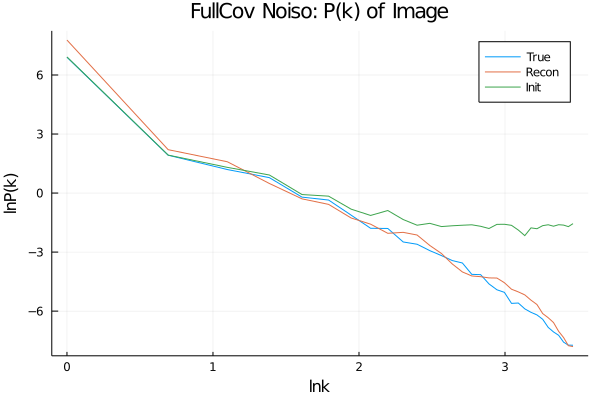

In [20]:
kbins=convert(Array{Float64}, collect(1:32))
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

Moving closer to the target than I want to. L1recon < L1true. 
**Let's increase Lambda to fix this?**

In [21]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/1000_1-0_full_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask])
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True271.13355388014503
0.08924165728318675
Init388.091139523465
0.0
Recon6.279469031823527
0.2999873710540242


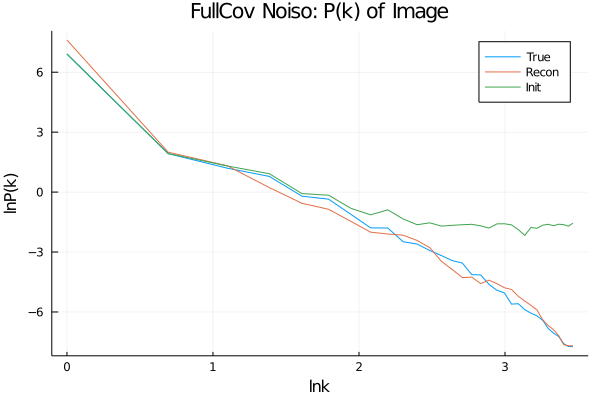

In [22]:
kbins= convert(Array{Float64}, collect(1:32))
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

In [23]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/1000_10_full_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask])
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True271.13355388014503
0.8924165728318676
Init388.091139523465
0.0
Recon7.196722678076889
1.1711584235470576


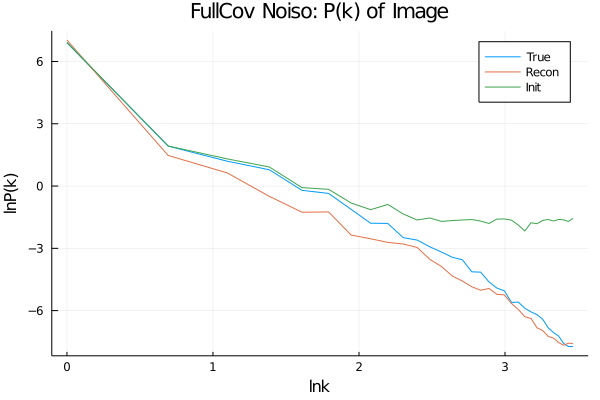

In [24]:
kbins= convert(Array{Float64}, collect(1:32))
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

In [25]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/100_0-01_full_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...))
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...))
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...))
s_smooth = log.(DHC_compute_wrapper(imfilter(gttarget["init"], Kernel.gaussian(0.8)), filter_hash, norm=false; dhc_args...))
function J_hashindices(J_values, fhash)
    jindlist = []
    for jval in J_values
        push!(jindlist, findall(fhash["J_L"][:, 1].==jval))
    end
    return vcat(jindlist'...)
end

function J_S1indices(J_values, fhash)
    #Assumes this is applied to an object of length 2+Nf+Nf^2 or 2+Nf
    return J_hashindices(J_values, fhash) .+ 2
end


LoadError: ArgumentError: No file exists at given path: ../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/100_0-01_full_triu.jld2

In [26]:
Jfiltidx = J_hashindices([0, 1, 2, 3], filter_hash)
JS1ind = J_S1indices([0, 1, 2, 3], filter_hash)

LoadError: UndefVarError: J_hashindices not defined

In [27]:
struesel = s_true[JS1ind]
sinitsel = s_init[JS1ind]
sreconsel = s_recon[JS1ind]
ssmoothsel = s_smooth[JS1ind]

LoadError: UndefVarError: JS1ind not defined

In [28]:
sfdall = readsfd_fromsrc("../../data/dust10000.fits", 64, logbool=false)
dbn = get_dbn_coeffs(sfdall, filter_hash, dhc_args, coeff_mask=nothing)

10000 slices


10000×1192 Array{Float64,2}:
 0.0361376  9.04943e-6   0.000514045  0.00113941   …  0.0313476   0.000457062
 0.289418   0.00257863   0.0574735    0.274282        1.69589     0.0211946
 0.0506923  5.60371e-5   0.00152274   0.00294826      0.0743567   0.00169278
 0.0341559  2.58829e-5   0.000478117  0.00128632      0.0303609   0.000482999
 0.170677   0.000401088  0.0147206    0.0210937       0.790839    0.0137406
 0.120943   0.000501101  0.00548136   0.0124099    …  0.336582    0.00456656
 0.063558   8.47624e-5   0.00169041   0.00435979      0.0845048   0.0010539
 0.192367   0.00153715   0.0379013    0.11789         1.07505     0.019009
 0.0707273  9.83063e-5   0.00226754   0.01116         0.128587    0.00240479
 0.125574   0.000264443  0.00531572   0.0112585       0.296421    0.00336588
 0.0656378  0.000475194  0.00244057   0.0096468    …  0.139068    0.0030072
 0.0421977  0.000125084  0.000934353  0.00418621      0.0541982   0.000994211
 0.0386173  3.68446e-5   0.000589672  0.00215856  

In [29]:
logdbn = log.(dbn)

10000×1192 Array{Float64,2}:
 -3.32042  -11.6128   -7.5732   -6.77724  …  -7.56084  -3.46262    -7.69069
 -1.23988   -5.9605   -2.85643  -1.2936      -3.01588   0.528205   -3.85401
 -2.98198   -9.7895   -6.48725  -5.82654     -5.85918  -2.59888    -6.38139
 -3.37682  -10.5619   -7.64565  -6.65597     -6.86559  -3.4946     -7.6355
 -1.76798   -7.82133  -4.21851  -3.85878     -4.24888  -0.234661   -4.2874
 -2.11243   -7.5987   -5.2064   -4.38926  …  -4.68458  -1.08891    -5.389
 -2.7558    -9.37566  -6.38278  -5.43533     -6.06498  -2.47095    -6.85526
 -1.64835   -6.47782  -3.27277  -2.138       -3.1035    0.0723635  -3.96284
 -2.64892   -9.22742  -6.08906  -4.49542     -5.73363  -2.05115    -6.03029
 -2.07486   -8.23788  -5.23709  -4.48663     -5.22627  -1.21597    -5.69407
 -2.7236    -7.65179  -6.01552  -4.64113  …  -4.57937  -1.97279    -5.80675
 -3.16539   -8.98653  -6.97566  -5.47596     -6.49233  -2.91511    -6.91356
 -3.25405  -10.2088   -7.43594  -6.13831     -7.29636  -3.15978

In [30]:
dbnmean = mean(logdbn, dims=1)[:]
meansel = dbnmean[JS1ind]

LoadError: UndefVarError: JS1ind not defined

In [31]:
p = plot(heatmap((sinitsel .- struesel)./abs.(struesel), title="Frac Res: Init-True"),
heatmap((sreconsel .- struesel)./abs.(struesel), title="Frac Res: Recon-True"),
heatmap((meansel .- struesel)./abs.(struesel), title="Frac Res: SFDTargMean-True"),
heatmap((sreconsel .- meansel)./abs.(struesel), title="Frac Res: Recon-SFDTargMean /True"))

LoadError: UndefVarError: sinitsel not defined

**Z scores**

In [32]:
siglog = std(logdbn, dims=1)

1×1192 Array{Float64,2}:
 0.949927  2.30556  2.07413  2.19625  …  2.00988  2.03672  1.8015  1.85022

In [33]:
using StatsBase
function distribution_percentiles(dbn, idx, perc)
    idxperc = zeros(size(idx))
    idxperc .= (x-> percentile(dbn[:, x], perc)).(idx)
    return idxperc
end
sfdmed = distribution_percentiles(logdbn, JS1ind, 50)

LoadError: UndefVarError: JS1ind not defined

In [34]:
sigsel = (siglog[:])[JS1ind]

LoadError: UndefVarError: JS1ind not defined

In [35]:
p = plot(heatmap((sinitsel .- struesel)./sigsel, title="Z Score: Init-True"),
heatmap((ssmoothsel .- struesel)./sigsel, title="Z Score: SmoothInit-True"),
heatmap((sreconsel .- struesel)./sigsel, title="Z Score: Recon-True"),
heatmap((meansel .- struesel)./sigsel, title="Z Score: SFDTargMean-True"),
heatmap((sreconsel .- meansel)./sigsel, title="Z Score: Recon-SFDTargMean"),
heatmap((sreconsel .- meansel)./sigsel, title="Z Score: Recon-SFDTargMean"), size=(900, 600))

LoadError: UndefVarError: sinitsel not defined

In [36]:
clims=(-1.0, 1.0)
cg = cgrad([:blue, :white, :red])
p = plot(heatmap((sinitsel .- struesel)./sigsel, title="Z Score: Init-True", clims=clims, c=cg),
heatmap((ssmoothsel .- struesel)./sigsel, title="Z Score: SmoothInit-True", clims=clims, c=cg),
heatmap((sreconsel .- struesel)./sigsel, title="Z Score: Recon-True", clims=clims, c=cg),
heatmap((meansel .- struesel)./sigsel, title="Z Score: SFDTargMean-True", clims=clims, c=cg),
heatmap((sreconsel .- meansel)./sigsel, title="Z Score: Recon-SFDTargMean", clims=clims, c=cg),
heatmap((sfdmed .- struesel)./sigsel, title="Z Score: SFDTargMedian - True", clims=clims, c=cg), size=(900, 600))

LoadError: UndefVarError: sinitsel not defined

In [37]:
clims=(-9.0, -4.0)
cg = cgrad([:blue, :white, :red])
p = plot(heatmap(struesel, title="True", clims=clims, c=cg),
heatmap(sinitsel, title="Init", clims=clims, c=cg),
heatmap(ssmoothsel, title="SmoothInit", clims=clims, c=cg),
heatmap(sreconsel, title="Recon", clims=clims, c=cg),
heatmap(meansel, title="SFDTargMean", clims=clims, c=cg),
heatmap(sfdmed, title="SFDTargMedian", clims=clims, c=cg), size=(900, 600))

LoadError: UndefVarError: struesel not defined

### Example of an image where log coeffs do NOT work well

In [38]:
##Case where this prescription does NOT work well
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/100_0-01_full_triu(1)"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_smooth = log.(DHC_compute_wrapper(imfilter(gttarget["init"], Kernel.gaussian(0.8)), filter_hash, norm=false; dhc_args...)[coeff_mask])
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True303.96004607560695
0.000663804345057021
Init396.16639104998467
0.0
Recon7.349865540909647
0.001610416378724573


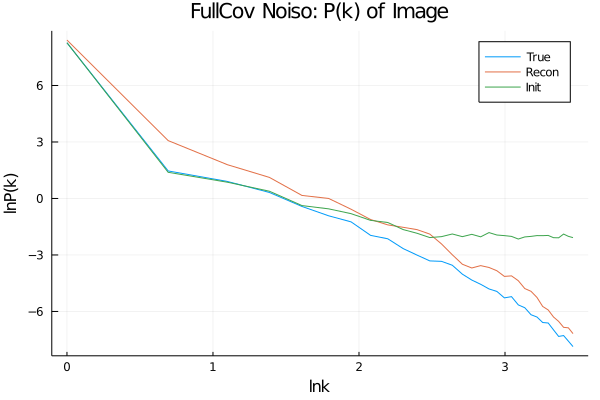

In [39]:
kbins=convert(Array{Float64}, collect(1:32))
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

In [40]:
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...))
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...))
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...))
s_smooth = log.(DHC_compute_wrapper(imfilter(gttarget["init"], Kernel.gaussian(0.8)), filter_hash, norm=false; dhc_args...))


1192-element Array{Float64,1}:
  -3.144031877784822
 -10.936546358015779
  -7.175948729949612
  -6.912069606541453
  -5.762511716584831
  -6.473896463693209
  -7.078632506472145
  -6.508813780032913
  -6.249305700008489
  -6.489125133947129
  -7.28006147739092
  -6.231527617295995
  -6.098724517252059
   ⋮
  -6.744409380148002
  -7.069597157118807
  -7.194831270753814
  -6.914446623549263
  -7.1622296921050195
  -7.55984535041072
  -7.280098569358903
  -7.075231305945022
  -6.946044616955598
  -7.293234714166373
  -2.855862523646302
  -6.88024988022421

In [41]:
struesel = s_true[JS1ind]
sinitsel = s_init[JS1ind]
sreconsel = s_recon[JS1ind]
ssmoothsel = s_smooth[JS1ind]
clims=(-9.0, -4.0)
cg = cgrad([:blue, :white, :red])
p = plot(heatmap(struesel, title="True", clims=clims, c=cg),
heatmap(sinitsel, title="Init", clims=clims, c=cg),
heatmap(ssmoothsel, title="SmoothInit", clims=clims, c=cg),
heatmap(sreconsel, title="Recon", clims=clims, c=cg),
heatmap(meansel, title="SFDTargMean", clims=clims, c=cg),
heatmap(sfdmed, title="SFDTargMedian", clims=clims, c=cg), size=(900, 600))

LoadError: UndefVarError: JS1ind not defined

In [42]:
clims=(-1.0, 1.0)
cg = cgrad([:blue, :white, :red])
p = plot(heatmap((sinitsel .- struesel)./sigsel, title="Z Score: Init-True", clims=clims, c=cg),
heatmap((ssmoothsel .- struesel)./sigsel, title="Z Score: SmoothInit-True", clims=clims, c=cg),
heatmap((sreconsel .- struesel)./sigsel, title="Z Score: Recon-True", clims=clims, c=cg),
heatmap((meansel .- struesel)./sigsel, title="Z Score: SFDTargMean-True", clims=clims, c=cg),
heatmap((sreconsel .- meansel)./sigsel, title="Z Score: Recon-SFDTargMean", clims=clims, c=cg),
heatmap((sfdmed .- struesel)./sigsel, title="Z Score: SFDTargMedian - True", clims=clims, c=cg), size=(900, 600))

LoadError: UndefVarError: sinitsel not defined

### Why are the zscores so high? 
Figured out: the zscores themselves aren't abnormal -- you were just using the diagonal of the inverse full covariance matrix and that's WRONG. Diagonal of inverse is NOT the variance.

In [43]:
datdir = "../../StandardizedExp/Nx64/Data_"
for f in [1, 10, 100, 1000, 10000]
    s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
end

In [44]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/1000_10_full_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask])
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True271.13355388014503
0.8924165728318676
Init388.091139523465
0.0
Recon7.196722678076889
1.1711584235470576


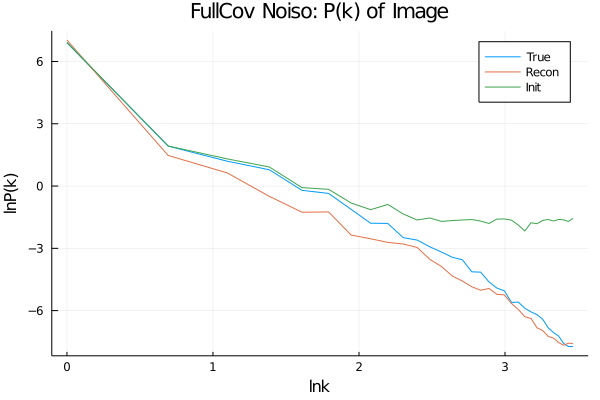

In [45]:
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

### Log Img's Coeffs

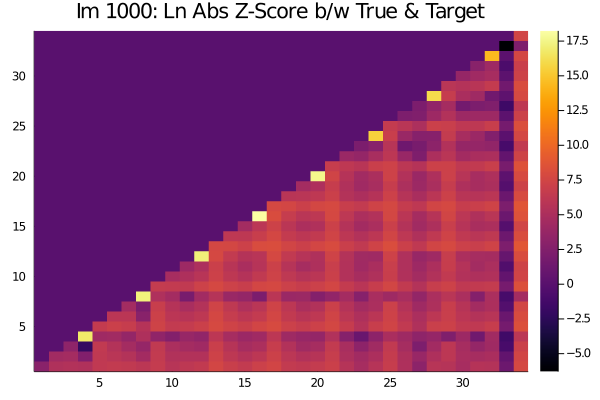

In [46]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/log_apd_noiso/1000_fullcov_triu"

gttarget = load(fname*".jld2")
s_targ_mean, s_targ_invcov = gttarget["dict"]["s_targ_mean"], gttarget["dict"]["s_invcov"]
dhc_args = Dict(:doS2=>false,  :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(log.(gttarget["true_img"]))
alinit = apodizer(log.(gttarget["init"]))
alrecon = apodizer(log.(gttarget["recon"]))

coeff_mask = gttarget["coeff_mask"]
s_true = DHC_compute_wrapper(log.(gttarget["true_img"]), filter_hash, norm=false; dhc_args...)[coeff_mask]
s_init = DHC_compute_wrapper(log.(gttarget["init"]), filter_hash, norm=false; dhc_args...)[coeff_mask]
s_recon = DHC_compute_wrapper(log.(gttarget["recon"]), filter_hash, norm=false; dhc_args...)[coeff_mask]
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
#446, 84503

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
#6e9, 0

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
#2.5e3, 6e4

ztrue_recon = (s_recon - s_true) .* diag(s_targ_invcov)
ztrue_target = (s_true - s_targ_mean) .* diag(s_targ_invcov)
zinit_target = (s_init - s_targ_mean) .* diag(s_targ_invcov)

scatter(log.(abs.(zinit_target)), log.(abs.(ztrue_recon)))
xlabel!("ln Abs Z score: Coeffs Target-Init")
ylabel!("ln Abs Z score: Coeffs Recon-True")

zscoremat = zeros(34, 34)
zscoremat[reshape(gttarget["coeff_mask"][3+34:end], (34, 34))] .= log.(abs.(ztrue_target))
heatmap(zscoremat, title="Im 1000: Ln Abs Z-Score b/w True & Target")


**Tuesday, 4/13**
1. Reg case: Init is more informative for the higher coeffs. Median >> mean
2. Log coeff: Init is also more informative for the higher coeffs here. Median~ mean here.
Z score:
3. IN ALL CASES, the full covariance inv's diagonal is inconsistent (orders of magnitude off from the true inverse variance). *Fixed. See "Why are z scores so high"?*
4. Unless there are repeated samples, this must be numerical range issues: ~100 of the 595 eigenvalues are <1e-6.
5. Code bug in SVD reconstruction.
6. Point out some of the weird images -- do we want to include these?

**Wednesday, 4/14**
1. Smooth is more informative of the higher coefficients than the init. It's definitely safer to use smooth_init in the coefficient based loss, since sometimes the higher coefficients are also affected by init (eg: Example where Log Coeffs do NOT work well).
2. The L=4-5 higher values is encoded in all true, init and smooth but lost in the mean. The benefit might be to be able to remember that.
3. What does smoothing do? Decreases variations between power at different scales but retains the original patterns.

In [47]:
gttarget["fhash"]

Dict{String,Any} with 18 entries:
  "theta_value"   => [0.0, 0.392699, 0.785398, 1.1781, 1.5708, 1.9635, 2.35619,…
  "j_value"       => [1.0, 2.0, 3.0, 4.0]
  "psi_ind_L"     => Int32[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1…
  "S2_iso_mat"    => …
  "Omega_index"   => 34
  "num_coeff"     => 1192
  "psi_index"     => Int32[1 5 … 25 29; 2 6 … 26 30; 3 7 … 27 31; 4 8 … 28 32]
  "J_L"           => Int32[0 0; 1 0; … ; 4 0; 4 1]
  "phi_index"     => 33
  "wd"            => [1.0, 1.0, 1.0, 2.0]
  "num_iso_coeff" => 156
  "pc"            => 1
  "fs_center_r"   => [16.0, 8.0, 4.0, 2.0]
  "filt_value"    => [[0.0218325, 0.0540773, 0.0284208, 0.0284208, 0.0540773, 0…
  "wd_cutoff"     => 1
  "npix"          => 64
  "S1_iso_mat"    => …
  "filt_index"    => Array{CartesianIndex{2},1}[[CartesianIndex(2, 9), Cartesia…

In [48]:
#Checking all 10 images to be safe
filt_hash = fink_filter_hash(1, 8, nx=64, Omega=true)

Dict{String,Any} with 19 entries:
  "filt_index"    => Array{CartesianIndex{2},1}[[CartesianIndex(5, 8), Cartesia…
  "psi_ind_L"     => Int32[1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 1, 1, 1, 1, 1…
  "S2_iso_mat"    => …
  "Omega_index"   => 34
  "num_coeff"     => 1192
  "psi_index"     => Int32[1 5 … 25 29; 2 6 … 26 30; 3 7 … 27 31; 4 8 … 28 32]
  "phi_index"     => 33
  "wd"            => [2.0, 2.0, 2.0, 2.0]
  "t"             => 1
  "wd_cutoff"     => 1
  "npix"          => 64
  "S1_iso_mat"    => …
  "theta_value"   => [0.0, 0.392699, 0.785398, 1.1781, 1.5708, 1.9635, 2.35619,…
  "J_L"           => Int32[0 0; 1 0; … ; 4 0; 4 1]
  "num_iso_coeff" => 156
  "fs_center_r"   => [16.0, 8.0, 4.0, 2.0]
  "filt_value"    => [[0.0089185, 0.0531124, 0.048333, 0.048333, 0.0531124, 0.0…
  "p"             => 2
  "j_value"       => [1.0, 2.0, 3.0, 4.0]

In [49]:
num=1000

1000

In [50]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/SFDTargSFDCov/reg_apd_noiso/LogCoeff/1000_0-01_full_triu"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_truebot = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...))
s_initbot = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...))
s_smoothbot = log.(DHC_compute_wrapper(imfilter(gttarget["init"], Kernel.gaussian(0.8)), filter_hash, norm=false; dhc_args...))
s_reconbot = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...))

1192-element Array{Float64,1}:
  -3.3914351141821504
 -10.545637944462566
  -7.177589052552278
  -6.288217340234273
  -5.718956693796892
  -6.325748428009598
  -7.120339088143373
  -6.228371477032441
  -5.667503368231648
  -5.492811677905582
  -7.144445691292695
  -6.226019227006753
  -5.59654229008543
   ⋮
  -7.01748543065207
  -6.872020546596044
  -7.441599373005976
  -7.082120328329247
  -6.9248609878454985
  -6.565128613416963
  -7.421059420364751
  -7.054811345671479
  -6.8790996266308095
  -6.728958888413241
  -3.2068545944145415
  -6.929627884689603

In [51]:
strueselbot = s_truebot[JS1ind]
sinitselbot = s_initbot[JS1ind]
ssmoothselbot = s_smoothbot[JS1ind]
clims=(-9.0, -4.0)
cg = cgrad([:blue, :white, :red])
p = plot(heatmap(strueselbot, title="True", clims=clims, c=cg),
heatmap(sinitselbot, title="Init", clims=clims, c=cg),
heatmap(ssmoothselbot, title="SmoothInit", clims=clims, c=cg))

LoadError: UndefVarError: JS1ind not defined

In [52]:
fname = "../../StandardizedExp/Nx64/Data_" * string(100)
println(fname)
dat = load(fname*".jld2")
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

coeff_mask = gttarget["coeff_mask"]
ds_true = log.(DHC_compute_wrapper(dat["true_img"], gttarget["fhash"], norm=false; dhc_args...))
ds_init = log.(DHC_compute_wrapper(dat["init"], gttarget["fhash"], norm=false; dhc_args...))
ds_smooth = log.(DHC_compute_wrapper(imfilter(dat["init"], Kernel.gaussian(0.8)), gttarget["fhash"], norm=false; dhc_args...))


struesel = ds_true[JS1ind]
sinitsel = ds_init[JS1ind]
ssmoothsel = ds_smooth[JS1ind]
clims=(-9.0, -4.0)
cg = cgrad([:blue, :white, :red])
zlims = (-1.0, 1.0)
p = plot(heatmap(struesel, title="True", clims=clims, c=cg),
heatmap(sinitsel, title="Init", clims=clims, c=cg),
heatmap(ssmoothsel, title="SmoothInit", clims=clims, c=cg))

../../StandardizedExp/Nx64/Data_100


LoadError: UndefVarError: JS1ind not defined

## Getting Optimization with Only S1 right

### LogCoeff

In [53]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/S1only/SFDTargSFDCov/reg_apd_noiso/LogCoeff/1000_full_eps10"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask])
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True18.71574511946675
0.008924165728318676
Init110.44358396146511
0.0
Recon0.2717108833346694
0.09097524200849058


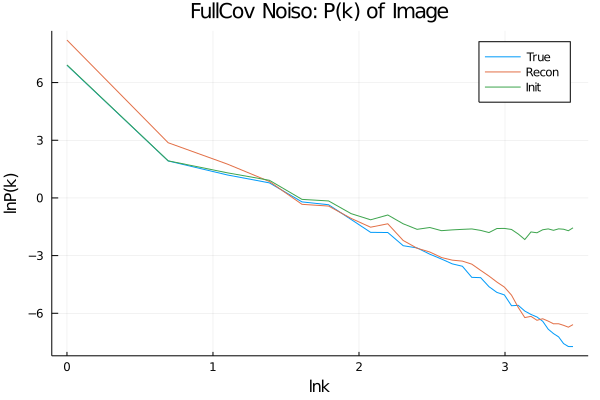

In [54]:
kbins=convert(Array{Float64}, collect(1:32))
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")

In [55]:
fname = "../../StandardizedExp/Nx64/noisy_stdtrue/S1only/SFDTargSFDCov/reg_apd_noiso/LogCoeff/100_full_eps10"
gttarget = load(fname*".jld2")
filter_hash = gttarget["fhash"]
s_targ_mean, s_targ_invcov = gttarget["dict"]["fs_targ_mean"], gttarget["dict"]["fs_invcov"]
dhc_args = Dict(:doS2=>false, :doS20=>true, :apodize=>true, :iso=>false)

altrue = apodizer(gttarget["true_img"])
alinit = apodizer(gttarget["init"])
alrecon = apodizer(gttarget["recon"])

coeff_mask = gttarget["coeff_mask"]
s_true = log.(DHC_compute_wrapper(gttarget["true_img"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_init = log.(DHC_compute_wrapper(gttarget["init"], filter_hash, norm=false; dhc_args...)[coeff_mask])
s_recon = log.(DHC_compute_wrapper(gttarget["recon"], filter_hash, norm=false; dhc_args...)[coeff_mask])
ltruecheck = ( 0.5 .* (s_true - s_targ_mean)' * s_targ_invcov * (s_true - s_targ_mean))[1]
l2true = 0.5*gttarget["dict"]["lambda"]*sum((alinit - altrue).^2)
println("True", ltruecheck)
println(l2true)

l1init = ( 0.5 .* (s_init - s_targ_mean)' * s_targ_invcov * (s_init - s_targ_mean))[1]
l2init = 0.5*gttarget["dict"]["lambda"]*sum((alinit - alinit).^2)
println("Init", l1init)
println(l2init)

l1recon = ( 0.5 .* (s_recon - s_targ_mean)' * s_targ_invcov * (s_recon - s_targ_mean))[1]
l2recon = 0.5*gttarget["dict"]["lambda"]*sum((alrecon - alinit).^2)
println("Recon", l1recon)
println(l2recon)


True23.149541232333995
0.006638043450570209
Init107.73101221318592
0.0
Recon0.22512806853093342
0.02018479900845506


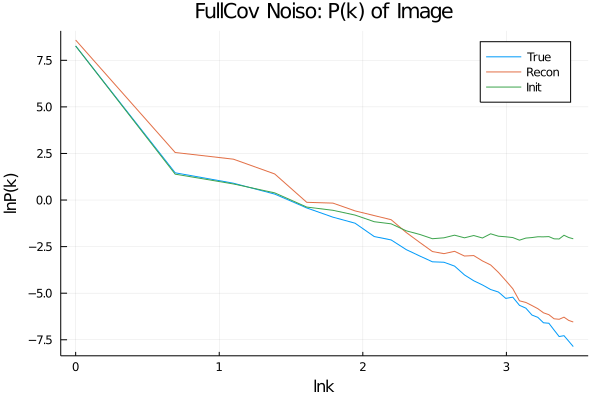

In [56]:
kbins=convert(Array{Float64}, collect(1:32))
true_ps = calc_1dps(apodizer(gttarget["true_img"]), kbins)
recon_ps = calc_1dps(apodizer(gttarget["recon"]), kbins)
init_ps = calc_1dps(apodizer(gttarget["init"]), kbins)
p = plot(log.(kbins), log.(true_ps), label="True")
plot!(log.(kbins), log.(recon_ps), label="Recon")
plot!(log.(kbins), log.(init_ps), label="Init")
plot!(title="FullCov Noiso: P(k) of Image")
xlabel!("lnk")
ylabel!("lnP(k)")